# Recurrent Neural Networks
---
# Predicting Stock Prices through an LSTM model

In [1]:
''' Linear Algebra '''
import pandas as pd
import numpy as np

'''Data visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [2]:
''' Handling timestamps'''
import datetime
from datetime import datetime

In [3]:
url = 'https://raw.githubusercontent.com/timjab92/cryptotradingindicator/master/data/BTCUSD_4hours.csv'

data = pd.read_csv(url)
# Dataset is now stored in a Pandas Dataframe

In [4]:
data = data.drop(columns="Unnamed: 0").set_index("date")
data = data[10000:]
data

,open,high,low,close,volume,log_open,log_high,log_low,log_close
date,,,,,,,,,
2016-09-11 16:00:00,622.530173,622.773815,622.393815,622.601965,0.645503,6.433792,6.434183,6.433573,6.433907
2016-09-11 20:00:00,608.858585,609.295377,608.338821,608.752830,21.064810,6.411376,6.412097,6.410514,6.411200
2016-09-12 00:00:00,604.478168,604.792618,604.236335,604.450576,3.045742,6.404364,6.404884,6.403964,6.404318
2016-09-12 04:00:00,605.892222,606.177516,605.676405,605.881569,2.487445,6.406701,6.407171,6.406345,6.406684
2016-09-12 08:00:00,605.702602,606.161735,605.157959,605.682296,5.324050,6.406387,6.407145,6.405488,6.406353
...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,48769.308417,48787.711375,48749.417500,48769.737750,1.697971,10.794844,10.795222,10.794435,10.794853
2021-08-22 16:00:00,48591.665708,48605.941333,48574.903375,48591.580833,0.463362,10.791204,10.791498,10.790859,10.791202
2021-08-22 20:00:00,48807.713542,48825.874417,48791.558000,48810.168750,0.605696,10.795610,10.795982,10.795279,10.795660


In [5]:
import requests
def get_coingecko():
    #ohlc
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=30"
    response = requests.get(url).json()
    #cleaning
    data_api = pd.DataFrame(response, columns = ['unix_time','open', 'high', 'low', 'close'])
    data_api["Date"] = pd.to_datetime(data_api["unix_time"], unit='ms')
    data_api = data_api.drop(columns='unix_time').set_index('Date')

    #volume
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30"
    response = requests.get(url).json()

    volume = pd.DataFrame(response['total_volumes'], columns=["unix_time","volume"])
    volume['date'] = pd.to_datetime(pd.to_datetime(volume['unix_time'],unit='ms').dt.strftime("%Y/%m/%d, %H:00:00"))
    volume = volume.drop(columns='unix_time').set_index('date')

    #resample hourly into 4h
    volume = volume.resample("4H").mean()

    #concatinate
    volume = volume[-180:]
    data_api = data_api[-181:-1]
    full = pd.concat([data_api, volume], axis=1)
    full.columns=['open', 'high', 'low', 'CLOSE', 'volume']

    for x in ['open', 'high', 'low', 'CLOSE']:
        full[f'log_{x}'] = full[x].apply(lambda x: np.log(x))

    data_api = full.copy()

    return data_api


def feature_engineer(data):
    """
    Adds the EMAs, StochRSI, BollingerBands and Volume Rate of Change to the dataframe
    """
    add_ema(data)
    add_stoch_rsi(data)
    add_bollinger(data,data.close)
    add_vol_roc(data)
    return data

## add other features

def add_ema(data, tspan=[12,26,20,50,34,55]):
    """
    Adds Exponential Moving Averages (EMA) to the dataframe. The default timeframes are 12,26,20,50,34 and 55.
    """
    for t in tspan:
        data[f'ema{t}'] = data.close.ewm(span=t).mean()
        data[f'dist_ema{t}'] = data['close'] - data[f'ema{t}']
    return data


def computeRSI(data, window=14):
    """
    Computes the Relative Stregth Index for a given dataset and the window can be defined. Its default value is 14.
    """
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=window-1 so we get decay alpha=1/window
    up_chg_avg   = up_chg.ewm(com=window-1 , min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window-1 , min_periods=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi


def stoch_rsi(rsi, d_window=3, k_window=3, window=14):
    """
    Computes the stochastic RSI. Default values are d=3, k=3, window=14.
    """
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D  


def add_stoch_rsi(data, d_window=3, k_window=3, window=14):
    data['rsi'] = computeRSI(data['close'], window)
    data['K'], data['D'] = stoch_rsi(data['rsi'], d_window, k_window, window)
    return data


def get_bollinger_bands(prices, rate=20):
    sma = prices.rolling(rate).mean() # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return sma, bollinger_up, bollinger_down


def add_bollinger(data, prices, rate=20):
    data['sma'], data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(prices)
    for i in ['bollinger_up', 'bollinger_down']:
        data[f'dist_{i}'] = data['close'] - data[i]
    return data


def add_vol_roc(data):
    data['vol_roc'] = data.volume.pct_change()
    return data


In [6]:
def get_train_data():
    """
    Returns the raw training dataset for the price of bitcoin since 31.12.2011.
    The index is set to the date.
    """
    data = pd.read_csv("../data/BTCUSD_4hours.csv")
    data['date'] = pd.to_datetime(data.date)
    data_train = data.drop(columns="Unnamed: 0").set_index("date")
    return data_train


def minmaxscaling(data_train):
    """
    applies the minmaxscaler to the training set. Attention! Output needs to be
    defined for data_train_scaled, min1 and range1!!
    """
    minmax_scaler = MinMaxScaler(feature_range=(0, 1))
    minmax_scaler.fit(data_train)
    data_train_scaled = minmax_scaler.transform(data_train)
    #    min1 = minmax_scaler.data_min_  # [5:9] for log_prices
    #    range1 = minmax_scaler.data_range_  #[5:9]
    return data_train_scaled, minmax_scaler


def get_xgecko(length=60, horizon=1):
    """
    Calls the coingecko API and returns the data used for prediction.
    x_gecko.shape == (no_sequ , length, no_features)
    """
    x_gecko = feature_engineer(get_coingecko())[['log_close']][-length:]
    #get scaler the long way
    data_train = feature_engineer(get_train_data())[['log_close']]
    data_train_scaled, scaler = minmaxscaling(data_train)

    x_gecko_scaled = scaler.transform(x_gecko)
    x_gecko = np.array(x_gecko_scaled)
    x_gecko = np.reshape(x_gecko, (horizon, length, 1))
    return x_gecko

### Daily return

$ return = \frac{new - old}{old} $

In [7]:
data = feature_engineer(data)

In [8]:
data['4h Return'] = data['close'].pct_change()
data['4h Gradient'] = data['close'].diff()

In [9]:
data['boll_width'] = data['bollinger_up'] - data['bollinger_down']

In [10]:
data = data.dropna()

In [11]:
data

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,D,sma,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc,4h Return,4h Gradient,boll_width
date,,,,,,,,,,,,,,,,,,,,,
2016-09-16 20:00:00,606.420076,606.511450,606.326031,606.412748,2.307185,6.407572,6.407723,6.407417,6.407560,606.877499,...,68.828642,607.386236,609.507000,605.265473,-3.094252,1.147275,-0.592995,0.001020,0.618162,4.241527
2016-09-17 00:00:00,606.393333,606.546449,606.200652,606.373841,0.914466,6.407528,6.407780,6.407210,6.407496,606.799699,...,64.814860,607.390858,609.501865,605.279851,-3.128024,1.093990,-0.603644,-0.000064,-0.038908,4.222014
2016-09-17 04:00:00,605.275088,605.384737,605.165702,605.290175,0.945083,6.405683,6.405864,6.405502,6.405707,606.566669,...,58.095296,607.238168,609.495591,604.980744,-4.205415,0.309431,0.033480,-0.001787,-1.083665,4.514846
2016-09-17 08:00:00,605.660526,605.763263,605.491368,605.612421,1.887662,6.406319,6.406488,6.406039,6.406239,606.419436,...,51.528814,607.137792,609.499844,604.775741,-3.887423,0.836680,0.997351,0.000532,0.322246,4.724103
2016-09-17 12:00:00,605.679435,605.831129,605.474355,605.635484,1.246336,6.406350,6.406601,6.406012,6.406278,606.298533,...,47.524728,607.032466,609.467803,604.597130,-3.832319,1.038354,-0.339746,0.000038,0.023063,4.870673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,48769.308417,48787.711375,48749.417500,48769.737750,1.697971,10.794844,10.795222,10.794435,10.794853,48667.353971,...,49.144985,47966.601915,50912.659422,45020.544407,-2142.921672,3749.193343,2.306553,-0.008789,-432.428292,5892.115014
2021-08-22 16:00:00,48591.665708,48605.941333,48574.903375,48591.580833,0.463362,10.791204,10.791498,10.790859,10.791202,48655.696565,...,35.095575,48165.535906,50660.931862,45670.139951,-2069.351028,2921.440883,-0.727108,-0.003653,-178.156917,4990.791911
2021-08-22 20:00:00,48807.713542,48825.874417,48791.558000,48810.168750,0.605696,10.795610,10.795982,10.795279,10.795660,48679.461517,...,19.301294,48355.680231,50371.206423,46340.154040,-1561.037673,2470.014710,0.307177,0.004498,218.587917,4031.052383


## BITCOIN Price

In [12]:
import seaborn as sns

<AxesSubplot:>

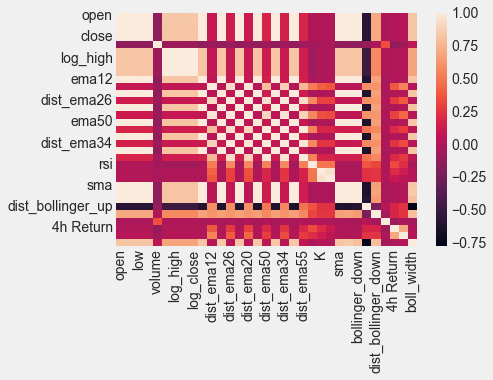

In [13]:
pd.set_option('display.max_columns', None)
sns.heatmap(data.corr())

In [14]:
data.keys()

Index(['open', 'high', 'low', 'close', 'volume', 'log_open', 'log_high',
       'log_low', 'log_close', 'ema12', 'dist_ema12', 'ema26', 'dist_ema26',
       'ema20', 'dist_ema20', 'ema50', 'dist_ema50', 'ema34', 'dist_ema34',
       'ema55', 'dist_ema55', 'rsi', 'K', 'D', 'sma', 'bollinger_up',
       'bollinger_down', 'dist_bollinger_up', 'dist_bollinger_down', 'vol_roc',
       '4h Return', '4h Gradient', 'boll_width'],
      dtype='object')

In [15]:
selected_features=['close','4h Return','rsi','dist_bollinger_down','dist_bollinger_up']
#21,99 emas

In [16]:
selected_data = data[selected_features]
selected_data

,close,4h Return,rsi,dist_bollinger_down,dist_bollinger_up
date,,,,,
2016-09-16 20:00:00,606.412748,0.001020,39.993174,1.147275,-3.094252
2016-09-17 00:00:00,606.373841,-0.000064,39.851441,1.093990,-3.128024
2016-09-17 04:00:00,605.290175,-0.001787,36.022306,0.309431,-4.205415
2016-09-17 08:00:00,605.612421,0.000532,37.932159,0.836680,-3.887423
2016-09-17 12:00:00,605.635484,0.000038,38.074638,1.038354,-3.832319
...,...,...,...,...,...
2021-08-22 12:00:00,48769.737750,-0.008789,61.965840,3749.193343,-2142.921672
2021-08-22 16:00:00,48591.580833,-0.003653,59.340648,2921.440883,-2069.351028
2021-08-22 20:00:00,48810.168750,0.004498,61.496021,2470.014710,-1561.037673


<AxesSubplot:>

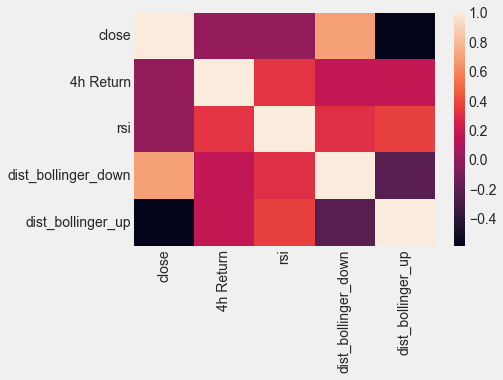

In [17]:
sns.heatmap(selected_data.corr())

In [18]:
len(selected_data)

10809

In [19]:
np.array(selected_data)[1][0]

606.3738405797101

In [20]:
def difference(dataset, interval=1):
    dataset = np.array(dataset)
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value[0])
    return pd.DataFrame(diff)

In [21]:
#selected_data = difference(selected_data, 1)

In [22]:
selected_data

,close,4h Return,rsi,dist_bollinger_down,dist_bollinger_up
date,,,,,
2016-09-16 20:00:00,606.412748,0.001020,39.993174,1.147275,-3.094252
2016-09-17 00:00:00,606.373841,-0.000064,39.851441,1.093990,-3.128024
2016-09-17 04:00:00,605.290175,-0.001787,36.022306,0.309431,-4.205415
2016-09-17 08:00:00,605.612421,0.000532,37.932159,0.836680,-3.887423
2016-09-17 12:00:00,605.635484,0.000038,38.074638,1.038354,-3.832319
...,...,...,...,...,...
2021-08-22 12:00:00,48769.737750,-0.008789,61.965840,3749.193343,-2142.921672
2021-08-22 16:00:00,48591.580833,-0.003653,59.340648,2921.440883,-2069.351028
2021-08-22 20:00:00,48810.168750,0.004498,61.496021,2470.014710,-1561.037673


### Temporal Train-Test Split

In [23]:
train_percentage = 95

In [24]:
train_len = int(len(selected_data) * train_percentage/100)
train_len

10268

In [25]:
data_train = selected_data[:train_len]
data_test = selected_data[train_len:]


## LSTM

In [26]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler(feature_range = (0,1))

minmax_scaler.fit(data_train)

data_train_scaled = minmax_scaler.transform(data_train)
data_test_scaled = minmax_scaler.transform(data_test)

In [27]:
minmax_scaler.data_max_

array([6.43385212e+04, 1.35906830e-01, 9.65172066e+01, 1.22061219e+04,
       1.91146622e+03])

In [28]:
minmax_scaler.data_min_

array([ 5.94187857e+02, -1.84592994e-01,  4.66356567e+00, -2.20500954e+03,
       -1.38781883e+04])

In [29]:
min1 = minmax_scaler.data_min_[0]
min1

594.1878571428572

In [30]:
range1 = minmax_scaler.data_range_[0]
range1

63744.333309523805

### Creating subsequences...

In [31]:
window_size = 18 # test with small window size
horizon = 3 #number of predictions into the future :) 
data_train_subsequences = []
fake_y_train = []
for k in range(len(data_train_scaled)-(window_size-1)-horizon):
    data_train_subsequences.append(data_train_scaled[k:k+window_size])
    fake_y_train.append(data_train_scaled[k+window_size:k+window_size+horizon]) #add [0] for log_price to be predicted

In [32]:
np.array(fake_y_train).shape

(10248, 3, 5)

In [33]:
X_train = np.array(data_train_subsequences)
y_train = np.array(fake_y_train)[:,:,0] #.reshape(-1,1)

In [34]:
X_train.shape

(10248, 18, 5)

In [35]:
y_train.shape

(10248, 3)

In [36]:
#with the same window_size & horizon as the train data
data_test_subsequences = []
fake_y_test = []
for k in range(len(data_test_scaled)-(window_size-1)-horizon):
    data_test_subsequences.append(data_test_scaled[k:k+window_size])
    fake_y_test.append(data_test_scaled[k+window_size:k+window_size+horizon])

In [37]:
X_test = np.array(data_test_subsequences)
y_test = np.array(fake_y_test)[:,:,0] #.reshape(-1,1)

In [38]:
X_test.shape

(521, 18, 5)

In [39]:
y_test.shape

(521, 3)

### LSTM

#### RNN Architecture

In [40]:
pd.DataFrame(y_test).shape

(521, 3)

In [41]:
# # from tensorflow.keras import metrics

# my_mae = metrics.MeanAbsoluteError(
#     name='mean_absolute_error', dtype=None
# )


In [42]:
from tensorflow.keras import Sequential, layers

# Build the LSTM model
model = Sequential()

model.add(layers.LSTM(units=128,
                     return_sequences = True,
                     activation = "tanh"
                    #activation = "relu"
                     #input_shape = X_train[0].shape)
                     ))

model.add(layers.LSTM(units=64,
                      return_sequences = False,
                      activation = "relu"  
                    #activation = "relu"
                     ))

# model.add(layers.Dense(25,
#                          activation="relu"))
model.add(layers.Dense(32,
                        activation = "tanh" 
                       #activation="relu"
                      ))
#model.add(layers.Dense(16,activation="relu"))
model.add(layers.Dense(8,
                       activation = "relu"
                       #activation="relu"
                      ))
model.add(layers.Dense(3,
                      activation = "relu" 
                      #activation="relu"
                      ))

#model.summary()



2021-08-31 09:08:17.200845: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [43]:
model.compile(loss="mse",
             optimizer = "adam",#rmsprop
             metrics = "mae"#[my_mae]
             )

#### Training

In [44]:
#### perhaps create a validation and train sets by hand

In [45]:
from tensorflow.keras.callbacks import EarlyStopping 

es = EarlyStopping(patience = 5, 
                   restore_best_weights= True,
                   monitor = "mae")

history = model.fit(X_train, y_train,
          validation_split = 0.2,
         batch_size=16,
         epochs=15,
         verbose = 1,
         callbacks = [es]
                   )

2021-08-31 09:08:17.271190: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
513/513 [==============================] - 9s 13ms/step - loss: 2.2913e-04 - mae: 0.0079 - val_loss: 0.0206 - val_mae: 0.0960
Epoch 2/15
513/513 [==============================] - 6s 12ms/step - loss: 3.7555e-05 - mae: 0.0046 - val_loss: 0.0108 - val_mae: 0.0674
Epoch 3/15
513/513 [==============================] - 6s 12ms/step - loss: 3.5706e-05 - mae: 0.0043 - val_loss: 0.0131 - val_mae: 0.0782
Epoch 4/15
513/513 [==============================] - 6s 13ms/step - loss: 2.7673e-05 - mae: 0.0038 - val_loss: 0.0108 - val_mae: 0.0661
Epoch 5/15
513/513 [==============================] - 6s 12ms/step - loss: 2.4578e-05 - mae: 0.0036 - val_loss: 0.0078 - val_mae: 0.0552
Epoch 6/15
513/513 [==============================] - 6s 11ms/step - loss: 1.9397e-05 - mae: 0.0031 - val_loss: 0.0082 - val_mae: 0.0576
Epoch 7/15
513/513 [==============================] - 6s 11ms/step - loss: 1.9445e-05 - mae: 0.0032 - val_loss: 0.0070 - val_mae: 0.0518
Epoch 8/15
513/513 [=====================

In [46]:
def plot_loss_mae(history):
    
    fig, ax =plt.subplots(1,2,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
#     # --- MAE

#     ax[1].plot(history.history['mean_absolute_error'])
#     ax[1].plot(history.history['val_mean_absolute_error'])
#     ax[1].set_title('Model MAE', fontsize = 18)
#     ax[1].set_xlabel('Epoch', fontsize = 14)
#     ax[1].set_ylabel('Recall', fontsize = 14)
#     ax[1].legend(['Train', 'Val'], loc='lower right') 
#     ax[1].grid(axis="x",linewidth=0.5)
#     ax[1].grid(axis="y",linewidth=0.5)   
    
    plt.show()
    

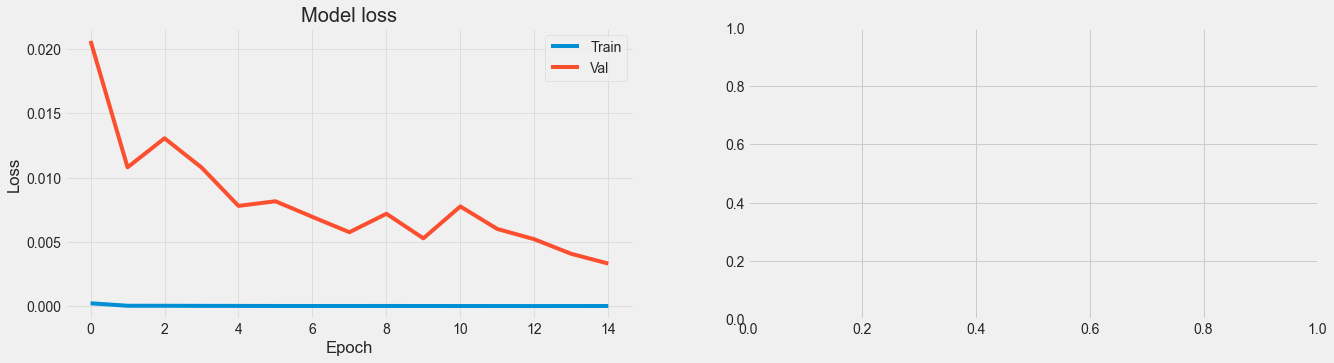

In [47]:
plot_loss_mae(history)

#### Evaluating

In [48]:
res = model.evaluate(X_test, np.array(y_test), verbose = 1)
res


17/17 [==============================] - 0s 5ms/step - loss: 0.0012 - mae: 0.0291


[0.0012246946571394801, 0.029120150953531265]

#### Predictions

In [49]:
predictions = model.predict(X_test)


In [50]:
len(predictions), len(y_test)

(521, 521)

In [51]:
predictions[0:3]

array([[0.5688451 , 0.5601654 , 0.56320196],
       [0.5567969 , 0.5483151 , 0.55033576],
       [0.5437645 , 0.53541946, 0.5365922 ]], dtype=float32)

In [52]:
y_test_unscaled = y_test * range1 + min1

In [53]:
predictions_unscaled = predictions * range1 + min1

The operation computed during a `MinMaxScaler` Operation is:

$$x_{scaled} = \frac{x - x_{min}}{x_{max}- x_{min}}$$

To descale it:

$$x = x_{scaled} * (x_{max}- x_{min}) + x_{min}$$

Or use the `inverse_transform` directly provided...

In [54]:
mae_1 = np.mean(np.abs(y_test_unscaled[:,0:1] - predictions_unscaled[:,0:1]))
mae_2 = np.mean(np.abs(y_test_unscaled[:,1:2] - predictions_unscaled[:,1:2]))
mae_3 = np.mean(np.abs(y_test_unscaled[:,2:3] - predictions_unscaled[:,2:3]))

In [55]:
print(mae_1)
print(mae_2)
print(mae_3)

1532.8158884756865
2111.5080466050854
1924.4127848197654


In [56]:
y_test_unscaled.shape

(521, 3)

In [57]:
predictions_unscaled.shape

(521, 3)

In [58]:
# # df =pd.DataFrame()
# df['y_test'] = pd.DataFrame(y_test_unscaled).apply(lambda x: np.exp(x))
# df['pred'] = pd.DataFrame(predictions_unscaled).apply(lambda x: np.exp(x))
# df['diff'] = df['y_test'] - df['pred']

In [59]:
# df

In [60]:
# np.mean(np.abs(df['diff']))

In [61]:
# plt.plot(df[['y_test', 'pred']])

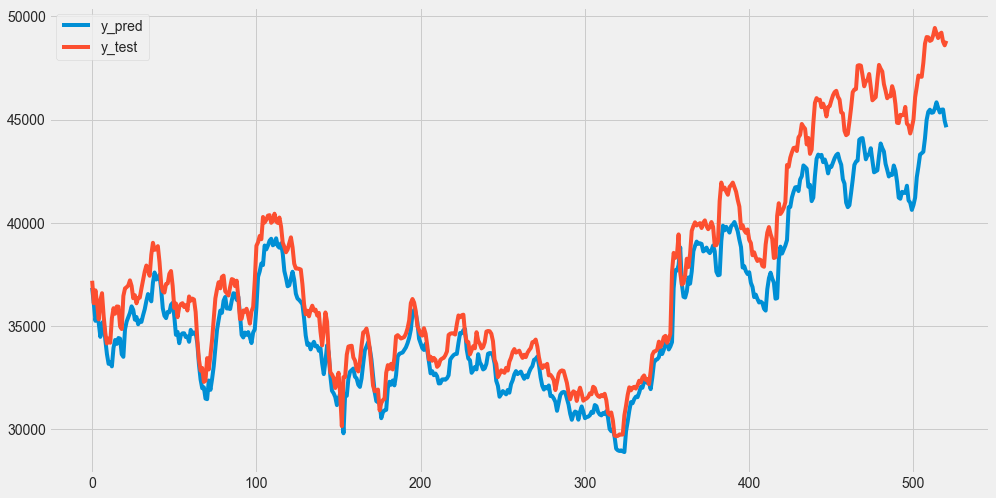

In [62]:
fig = plt.figure(figsize=(15, 8))

plt.plot(predictions_unscaled[:,0], label = "y_pred")
plt.plot(y_test_unscaled[:,0], label = "y_test")
plt.legend()
plt.show()

In [63]:
stop stop 

SyntaxError: invalid syntax (958000207.py, line 1)

# PREDICTION WITH COINGECKO!!!

In [ ]:
import requests

def get_coingecko():
    #ohlc
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=30"
    response = requests.get(url).json()
    #cleaning
    data_api = pd.DataFrame(response, columns = ['unix_time','open', 'high', 'low', 'close'])
    data_api["Date"] = pd.to_datetime(data_api["unix_time"], unit='ms')
    data_api = data_api.drop(columns='unix_time').set_index('Date')

    #volume
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30"
    response = requests.get(url).json()

    volume = pd.DataFrame(response['total_volumes'], columns=["unix_time","volume"])
    volume['date'] = pd.to_datetime(pd.to_datetime(volume['unix_time'],unit='ms').dt.strftime("%Y/%m/%d, %H:00:00"))
    volume = volume.drop(columns='unix_time').set_index('date')

    #resample hourly into 4h
    volume = volume.resample("4H").mean()

    #concatinate
    volume = volume[-180:]
    data_api = data_api[-181:-1]
    full = pd.concat([data_api, volume], axis=1)
    full.columns=['open', 'high', 'low', 'close', 'volume']

    for x in ['open', 'high', 'low', 'close']:
        full[f'log_{x}'] = full[x].apply(lambda x: np.log(x))

    data_api = full.copy()

    return data_api

def feature_engineer(data):
    """
    Adds the EMAs, StochRSI, BollingerBands and Volume Rate of Change to the dataframe
    """
    add_ema(data)
    add_stoch_rsi(data)
    add_bollinger(data,data.log_close)
    add_vol_roc(data)
    return data

In [ ]:
coingecko = feature_engineer(get_coingecko())
coingecko['4h Return'] = coingecko['close'].pct_change()
x_gecko = coingecko[selected_features][-160:]
x_gecko_scaled = minmax_scaler.transform(x_gecko)

In [ ]:
x_gecko

In [ ]:
coingecko[-3:]

In [ ]:
window_size=155

In [ ]:
x_gecko_subsequences = []
for k in range(len(x_gecko_scaled)-(window_size-1)-horizon):
    x_gecko_subsequences.append(x_gecko_scaled[k:k+window_size])

In [ ]:
x_gecko = np.array(x_gecko_subsequences)

In [ ]:
x_gecko.shape

In [ ]:
#x_gecko = np.array(x_gecko)
x_gecko = np.reshape(x_gecko, (-1,window_size,len(selected_features))) #[-horizon:,:,:]

x_gecko.shape

In [ ]:
predictions = model.predict(x_gecko)

predictions

In [ ]:
predictions_unscaled = predictions * range1 + min1

In [ ]:
np.exp(predictions_unscaled)

In [ ]:
from datetime import datetime
dateTimeObj = datetime.now()
print(dateTimeObj)

In [ ]:
close = pd.DataFrame(coingecko.close[-10:].reset_index().drop(columns='index'))

In [ ]:
close

In [ ]:
for i in range(len(close),len(close) + horizon):
    print(i)

In [ ]:
pred = pd.DataFrame(np.exp(predictions_unscaled), columns = ['close']).set_index(pd.Index(range(len(close),len(close) + horizon)))

In [ ]:
df = pd.DataFrame(np.exp(predictions_unscaled), columns = ['pred'])
df['gecko'] = coingecko['log_close']
df

In [ ]:
plt.plot(close)
plt.plot(pred)

In [ ]:
plt.plot(coingecko['close'][-20:])
plt.plot(predictions_unscaled)